# Volatility calculator

## (1) Realized volatility calculator

### (a) Yearly volatility

<>:98: SyntaxWarning: invalid escape sequence '\$'
<>:98: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Umbi Pumbi\AppData\Local\Temp\ipykernel_3272\3720744628.py:98: SyntaxWarning: invalid escape sequence '\$'
  price_array = df['Close/Last'].replace('[\$,]', '', regex=True).astype(float).to_numpy()
C:\Users\Umbi Pumbi\AppData\Local\Temp\ipykernel_3272\3720744628.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


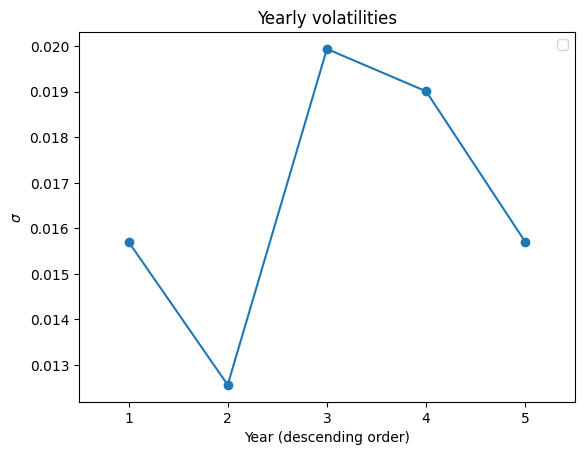

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# FUNCTIONS

def later_date(date, than):
    '''
    Compares 2 dates, returning True if the 1st one is later than the 2nd one, and False otherwise.

    Inputs:
        date (str): 1st date
        than (str): 2nd date
    
    Returns:
        bool: Is the 1st date later than the 2nd one?
    '''
    date = date.split("/")
    date = [int(x) for x in date]
    than = than.split("/")
    than = [int(x) for x in than]

    # Compare year
    if (date[2] > than[2]):
        return True
    elif (date[2] < than[2]):
        return False
    
    # Compare month
    elif (date[0] > than[0]):
        return True
    elif (date[0] < than[0]):
        return False
    
    # Compare day
    elif (date[1] > than[1]):
        return True
    else:
        return False


def split_yearly(data_frame):
    '''
    Finds the first index of each yearly interval

    Inputs:
        data_frame (pandas.core.frame.DataFrame): Data frame to split, must contain a column named "Date".
    
    Returns:
        list: List containing the first index of each split
    '''
    # Initialize output
    indexes = [0]

    # Date separating years
    date1 = data_frame.loc[0, "Date"].split("/")
    date1 = [int(x) for x in date1]

    # Loop that splits once per iteration
    keep_it_up_baby = True
    while (keep_it_up_baby):
        keep_it_up_baby = False
        # Lower year
        date1[2] = date1[2] - 1
        d = '/'.join(str(x) for x in date1)
        # Iterate to find first earlier than the splitting day
        for i in range(indexes[-1], len(data_frame)):
            if not later_date(data_frame.loc[i, "Date"], d):
                # Add the index
                indexes.append(i)
                keep_it_up_baby = True
                break

    return indexes


def simple_vol(data):
    '''
    Returns the standard deviation of a dataset (assuming mean is 0 or very small).

    Inputs:
        data (np.ndarray or list): Dataset
    
    Returns:
        Volatility, with unit equal to the time step between data points to the power of -1/2.
    '''
    return math.sqrt(sum(np.asarray(data) ** 2) / len(data))


# BODY

# Extract data frame
df = pd.read_csv('C:/Users/Umbi Pumbi/Documents/Quant/HistoricalData_1754588271947.csv') # Code works for data frames specifically in the format of downloaded Nasdaq historical data

# Compute returns
price_array = df['Close/Last'].replace('[\$,]', '', regex=True).astype(float).to_numpy()
returns = np.array([price_array[i] / price_array[i + 1] - 1 for i in range(len(price_array) - 1)])

# Split in yearly intervals
y_split_indexes = split_yearly(df.iloc[:-1])
yearly_splits = []
for i in range(len(y_split_indexes) - 1):
    yearly_splits.append(returns[y_split_indexes[i]:y_split_indexes[i + 1]])
yearly_splits.append(returns[y_split_indexes[-1]:])

# Compute volatilities
volatilities = np.array([math.sqrt(sum(yearly_splits[i] ** 2) / len(yearly_splits[i])) for i in range(5)]) # Numpy array with the yearly volatilties

# Plot results
x = range(1, len(volatilities) + 1)
plt.plot(x, volatilities, marker='o', linestyle='-')
plt.xticks(x)
plt.xlim(min(x) - 0.5, max(x) + 0.5)
plt.xlabel('Year (descending order)')
plt.ylabel(r'$\sigma$')
plt.title('Yearly volatilities')
plt.legend()


### (b) Fixed length, moving window

C:\Users\Umbi Pumbi\AppData\Local\Temp\ipykernel_3272\2083801857.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


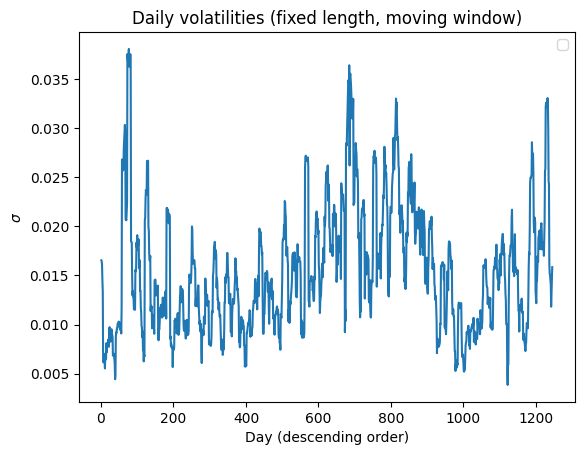

In [2]:
# Parameters
win = 10

# Calculate volatilities
volatilities = [simple_vol(returns[i:i + win]) for i in range(len(returns) - win + 1)]

# Plot results
x = range(1, len(volatilities) + 1)
plt.plot(x, volatilities, marker='', linestyle='-')
plt.xlabel('Day (descending order)')
plt.ylabel(r'$\sigma$')
plt.title('Daily volatilities (fixed length, moving window)')
plt.legend()


### (c) Exponentially weighed estimate

C:\Users\Umbi Pumbi\AppData\Local\Temp\ipykernel_3272\417001972.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


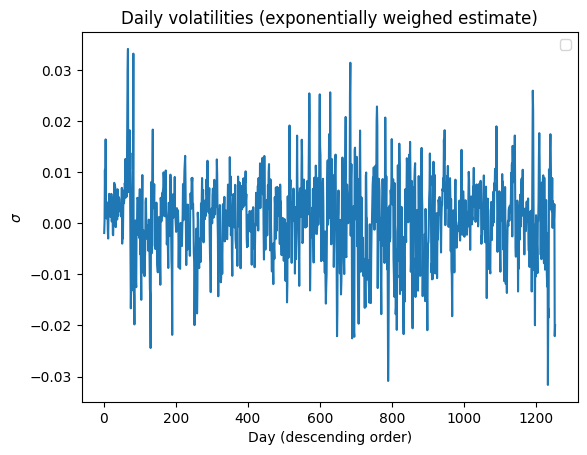

In [3]:
# Parameters
L = 0.6 #Must be strictly between 0 and 1

# Calculate volatilities
weighted = np.array([returns[j] * (L ** j) for j in range(len(returns))])
volatilities = [((1 - L) / (1 - L ** (len(weighted) - i))) * sum(weighted[i:]) / L ** i for i in range(len(weighted))]

# Plot results
x = range(1, len(volatilities) + 1)
plt.plot(x, volatilities, marker='', linestyle='-')
plt.xlabel('Day (descending order)')
plt.ylabel(r'$\sigma$')
plt.title('Daily volatilities (exponentially weighed estimate)')
plt.legend()

## (2) Implied volatility calculator

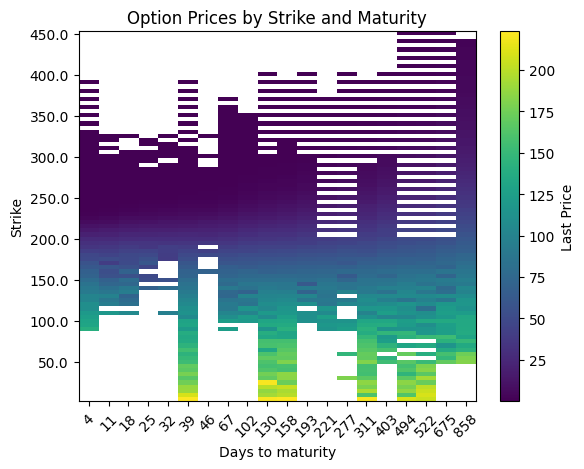

C:\Users\Umbi Pumbi\AppData\Local\Temp\ipykernel_3272\3800319401.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.imshow(np.where(fail_mask, 1.0, np.nan), origin='lower', aspect='auto', cmap=plt.cm.get_cmap('Reds', 2), vmin=0, vmax=1, alpha=1.0, interpolation='none')


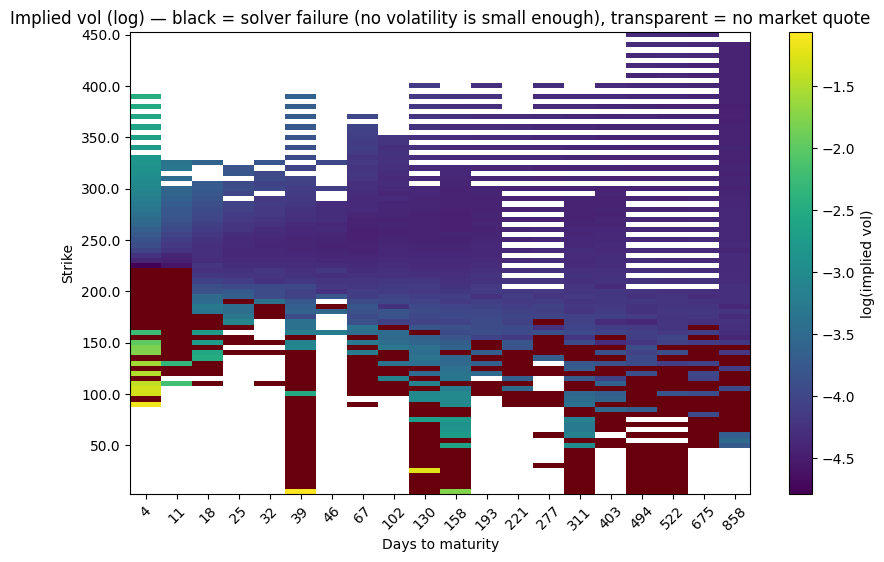

In [ ]:
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf
import datetime as dt

def option(op_class, E, T, sigma, r, S, D = 0, t = 0):
    '''
    Value of an option according to Black-Scholes

    Parameters:
        op_class (str): Call or put?
        E (float): Strike price.
        T (float): Maturity (in whatever units, as long as consistent with sigma and r), equal to time to maturity if t=0.
        sigma (float): Volatility.
        r (float): risk-free rate.
        S (float): Current stock price.
        D (float): Continuous dividend rate.
        t (float): current time (keep =0 to make T time to maturity, simpler).
    
    Returns:
        float: Value of the option
    '''
    d1 = (math.log(S / E) + (r - D + (1/2) * sigma ** 2) * (T - t)) / (sigma * math.sqrt(T - t))
    d2 = d1 - sigma * math.sqrt(T - t)
    if (op_class == "C"):
        return S * math.exp(-D * (T - t)) * norm.cdf(d1) - E * math.exp(-r * (T - t)) * norm.cdf(d2)
    elif (op_class == "P"):
        return -S * math.exp(-D * (T - t)) * norm.cdf(-d1) + E * math.exp(-r * (T - t)) * norm.cdf(-d2)
    else:
        raise ValueError(f'Please introduce a valid op_class: either "C" (Call) or "P" (Put)')

FAIL_MARKER = 999 # Must be positive
def implied_vol(V, op_class, E, T, r, S, D = 0, t = 0):
    '''
    Calculates implied volatility of an option.

    Parameters:
        V (float): Value of the option.
        op_class (str): Call or put?
        E (float): Strike price.
        T (float): Maturity (in whatever units, as long as consistent with sigma and r), equal to time to maturity if t=0.
        r (float): risk-free rate.
        S (float): Current stock price.
        D (float): Continuous dividend rate.
        t (float): current time (keep =0 to make T time to maturity, simpler).
    
    Returns:
        float: Value of the option
    '''
    def f(vol):
        return option(op_class, E, T, vol, r, S, D, t) - V

    # Initial interval in which to look for a solution
    lb, ub = 1e-14, 1
    # Maximum order of magnitude where we will look for a valid upper bound
    max = 4

    # Look for a valid interal to look for a solution
    if f(1e-14) < 0:
        if f(lb) * f(ub) > 0:
            for i in range(max):
                print(f(10 ** (i + 1)))
                # Check powers of 10 until we find bounds that allow for a root (have a sign change or zero-endpoint)
                if f(10 ** i) * f(10 ** (i + 1)) <= 0:
                    # Update lb, ub
                    lb = 10 ** i
                    ub = lb * 10
                    break
    else:
        # No solution small enough for imp_vol exists
        return FAIL_MARKER

    # Use Brent's method to find a root in the interval [lb, ub]
    # xtol=1e-14 ensures very high precision in the root without leading to infinite loops
    imp_vol = brentq(f, lb, ub, xtol=1e-14)

    return imp_vol



# BODY

# Parameters
ticker = yf.Ticker("AAPL") # Choose company
rfr = 0.04 # Today's yearly risk-free rate
current_price = ticker.info['regularMarketPrice'] # Current stock price
today = dt.date.today()
option_class = "C" # Choose whether to analyze calls ("C") or puts ("P")

# List of all times to maturity
expirations = ticker.options # List of available expiration dates (as string)
maturities = [(dt.datetime.strptime(ex, "%Y-%m-%d").date() - today).days for ex in expirations] # Calculate time to maturity with datetime package

# List of datasets (each corresponding to a maturity) of options at different strikes
opts = []
if option_class == "C":
    opts = [ticker.option_chain(expirations[i]).calls for i in range(len(expirations))]
elif option_class == "P":
    opts = [ticker.option_chain(expirations[i]).puts for i in range(len(expirations))]
else:
    raise ValueError(f'Please introduce a valid option_class: either "C" (Call) or "P" (Put)')

# 2-dimensional array (rows are maturities, sub-lists are strikes)
strikes_at_maturities = [opts[i]["strike"] for i in range(len(opts))]

# List of all strikes
m = min([strikes_at_maturities[i].iloc[0] for i in range(len(strikes_at_maturities))]) # Min strike
M = max([strikes_at_maturities[i].iloc[-1] for i in range(len(strikes_at_maturities))]) # Max strike
strikes = [m + 5 * i for i in range(int((M - m) / 5 + 1))] # List of strikes

# Call values matrix (rows are strikes, columns are maturities)
strike_maturity = np.full((len(strikes_at_maturities), int((M - m) / 5 + 1)), np.nan) # Initialize matrix, rows and colums are swapped (rows are maturities, columns are strikes), we'll change it at the end
for i in range(len(strikes_at_maturities)):
    for j in range(len(strikes_at_maturities[i])):
        strike_maturity[i, int((strikes_at_maturities[i].iloc[j] - m) / 5)] = opts[i].iloc[j]["lastPrice"] # Put call values in corresponding strike and maturity
strike_maturity = strike_maturity.T # Transpose

# Implied volatilities matrix
imp_vols = np.full(strike_maturity.shape, np.nan)
fail_mask = np.zeros(strike_maturity.shape, dtype=bool)
for i in range(imp_vols.shape[1]):
    for j in range(imp_vols.shape[0]):
        if not math.isnan(strike_maturity[j, i]):
        # If the call exists in yfinance
            vol1 = implied_vol(V=strike_maturity[j, i], op_class="C", E=strikes[j], T=maturities[i], r=(rfr / 365), S=current_price)
            if vol1 == FAIL_MARKER:
            # mark as failure (red overlay later)
                fail_mask[j, i] = True
            else:
            # store the valid implied volatility
                imp_vols[j, i] = vol1



# Plot call prices

tick_indices = [i for i, s in enumerate(strikes) if s % 50 == 0]
plt.imshow(strike_maturity, 
           origin='lower',  # make low strikes at the bottom
           aspect='auto',   # stretch to fit
           cmap='viridis')  # color map
plt.colorbar(label='Last Price')

plt.yticks(ticks=tick_indices, labels=[strikes[i] for i in tick_indices])
plt.xticks(ticks=range(len(maturities)), labels=[str(m) for m in maturities], rotation=45)

plt.xlabel('Days to maturity')
plt.ylabel('Strike')
plt.title('Option Prices by Strike and Maturity')
plt.show()



# Plot implied volatilities

log_vols = np.where((~np.isnan(imp_vols)) & (imp_vols > 0), np.log(imp_vols), np.nan)
# Plot the log-vol colormap (NaNs are transparent)
plt.figure(figsize=(10, 6))
plt.imshow(log_vols, origin='lower', aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar(label='log(implied vol)')
# Overlay failures (red squares). We set 1 where fail_mask True, else NaN.
plt.imshow(np.where(fail_mask, 1.0, np.nan), origin='lower', aspect='auto', cmap=plt.cm.get_cmap('Reds', 2), vmin=0, vmax=1, alpha=1.0, interpolation='none')
# ticks etc.
plt.yticks(ticks=tick_indices, labels=[strikes[i] for i in tick_indices])
plt.xticks(ticks=range(len(maturities)), labels=[str(m) for m in maturities], rotation=45)
plt.xlabel('Days to maturity')
plt.ylabel('Strike')
plt.title('Implied vol (log) — black = solver failure (no volatility is small enough), transparent = no market quote')
plt.show()


